## 分析PTT八卦版 大谷翔平 相關文章之詞彙關係
- 資料來源 : 八卦版的大谷翔平相關文章
- 日期區間 : 2022-01-01 ~ 2024-03-31
- 目的 : 透過TF-IDF, N-gram等方法找出文章和字詞間的關聯。

### 大綱
1. 套件說明 
2. 資料前處理
3. 找出重要詞彙 - 以TFIDF為例
4.  透過結巴斷詞與N-gram幫助建立斷詞字典
5.  Pairwise correlation
6. 計算文章相似度
7. 補充：建立Ngram預測模型

## 1. 套件說明

- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [7]:
pip install -U networkx

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [9]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [10]:
# cloab 字體設定

# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

In [11]:
#匯入資料
df = pd.read_csv('sna2024s.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,a14589761,Gossiping,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a94037501"", ...",110.26.71.183,2022-01-04 00:38:35,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05 22:31:19,XBOXFANS,Gossiping,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zero9613719""...",118.232.67.100,2022-01-06 00:39:27,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09 01:29:17,ReiKuromiya,Gossiping,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ah937609"", ""...",101.10.57.169,2022-01-10 00:31:00,ptt


###  資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [12]:
MetaData = df.copy()

# 填充缺失值為空字串
MetaData['artContent'] = MetaData['artContent'].fillna('')
# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05 22:31:19,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,媒體來源三立記者署名娛樂中心林亭妤報導完整新聞標題福原愛爆再婚被罵翻懶甩酸民突喊永遠幸福洩近...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09 01:29:17,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,有沒有如果大谷翔平加入女偶像團體唱唱跳跳右邊這神似大谷妹妹是不是看起來還不錯可愛


### 文章斷詞與整理

In [218]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [219]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [224]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,看大
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05 22:31:19,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,媒體來源三立記者署名娛樂中心林亭妤報導完整新聞標題福原愛爆再婚被罵翻懶甩酸民突喊永遠幸福洩近...,投麥
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09 01:29:17,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,有沒有如果大谷翔平加入女偶像團體唱唱跳跳右邊這神似大谷妹妹是不是看起來還不錯可愛,感覺


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF用來評估單詞對於文件的集合的重要程度。

In [ ]:
# 建立短句子範本
doc1 = """關心體壇動態，美國職棒洛杉磯道奇的看板球星大谷翔平，最近手感回溫，前場對上巨人敲出轉隊後首轟，今(6)日對上芝加哥小熊，又敲出兩分打點全壘打，大谷連續兩戰都炸裂，大聯盟生涯累積173轟，只差2轟就可以追平「酷斯拉」松井秀喜所創下的大聯盟日籍球員最多轟紀錄。洛杉磯道奇前進芝加哥踢館小熊，所有球迷聚焦的人，不用說當然就是看板球星大谷翔平了。從開季前，破紀錄大約風光加盟藍帽團，聲勢來到最高點，直到經歷前翻譯水原一平的涉賭風波，負面傳聞讓Ohtani難免受到影響，但大家熟悉的大谷準備要回來了，前場對巨人敲出轉隊後首轟，本場打小熊，沒有讓球迷等太久，5局上延續好手感，紅不讓又來囉！"""

doc2 = """大谷翔平在台灣時間今天凌晨飛往韓國前，公開1張6人合照，他身邊的女性引熱議，道奇證實這位是他太太、籃球選手田中真美子，不但球迷瘋了，國際媒體都爭相報導，而大谷翔平從宣布結婚到公開老婆，都是在特定的時間點，都讓人覺得他是有想法，而且超甜蜜。世界媒體都爭相報導大谷翔平在IG貼出的這張照片，尤其是即將在20、21日舉行大聯盟海外賽的地點韓國，韓媒不論是電視台、網路、平面都大幅報導，甚至財經新聞都參一腳。SBS電視台以「讓人意外結婚的大谷，在飛往韓國的飛機前首次公開妻子身份」為題報導，在這張照片中，除了有大谷的隊友山本由伸、翻譯水原一平，最引人注目的是大谷旁邊的那位女性。"""

doc3 = """大谷翔平在學生時代就創下很多讓人難以置信的傳說，例如一棒把球從場內打飛，飛到場外撞爛了人行紅綠燈；或是國中在比賽中投出了十七個三振，然而即使大谷屬於「天才型」，他的人生還是不可能一帆風順。
直到現在，花卷東高的宿舍牆上還貼著一張大谷翔平手寫的字條，他用大大的字寫著標題「最後的夏天」，內文字裡行間滿是不甘心。一二年，春天甲子園第一戰，花卷東高遇上由當時與大谷齊名的強投藤浪晉太郎領軍的大阪桐蔭高，那場比賽，擔任投手的大谷被大阪桐蔭高的強力打線擊潰，以二比九吞敗飲恨。大谷寫下字條，矢志在夏天甲子園扳回一城。"""

sample_df = pd.DataFrame({'doc':[1,2,3], 'text': [doc1, doc2, doc3]})

sample_df

,doc,text
0,1,關心體壇動態，美國職棒洛杉磯道奇的看板球星大谷翔平，最近手感回溫，前場對上巨人敲出轉隊後首轟...
1,2,大谷翔平在台灣時間今天凌晨飛往韓國前，公開1張6人合照，他身邊的女性引熱議，道奇證實這位是他...
2,3,大谷翔平在學生時代就創下很多讓人難以置信的傳說，例如一棒把球從場內打飛，飛到場外撞爛了人行紅...


資料清理

In [ ]:
sample_df['text'] = sample_df['text'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
sample_df = sample_df.assign(word = sample_df['text'].apply(getToken)).explode('word')

sample_df.head()

,doc,text,word
0,1,關心體壇動態美國職棒洛杉磯道奇的看板球星大谷翔平最近手感回溫前場對上巨人敲出轉隊後首轟今日對...,關心
0,1,關心體壇動態美國職棒洛杉磯道奇的看板球星大谷翔平最近手感回溫前場對上巨人敲出轉隊後首轟今日對...,體壇
0,1,關心體壇動態美國職棒洛杉磯道奇的看板球星大谷翔平最近手感回溫前場對上巨人敲出轉隊後首轟今日對...,動態
0,1,關心體壇動態美國職棒洛杉磯道奇的看板球星大谷翔平最近手感回溫前場對上巨人敲出轉隊後首轟今日對...,美國
0,1,關心體壇動態美國職棒洛杉磯道奇的看板球星大谷翔平最近手感回溫前場對上巨人敲出轉隊後首轟今日對...,職棒


#### 計算各文章的總詞彙數

In [ ]:
total_words = sample_df.groupby(['doc'], as_index=False).size().rename(columns={'size': 'total'})
total_words.head()

,doc,total
0,1,87
1,2,87
2,3,78


#### 計算各文章的各個詞彙數

In [ ]:
word_count = sample_df.groupby(['doc', 'word'], as_index = False).size()

word_count.rename(columns={'size': 'count'}, inplace=True)
word_count.sort_values('count', ascending=False).head()

,doc,word,count
153,3,大谷,6
83,2,大谷,6
15,1,大谷,4
81,2,報導,4
24,1,敲出,3


合併需要的資料欄位
- 合併 **每個詞彙在每篇文章中出現的次數** 與 **每篇文章的詞數**

In [ ]:
sample_merged = word_count.merge(total_words, on = 'doc', how = 'left')
sample_merged.head(3)

,doc,word,count,total
0,1,一平,1,87
1,1,不用說,1,87
2,1,不讓,1,87


ex:```一平```該詞彙出現在doc的次數為一次，且doc 1共有87個詞彙

#### 計算 TF值

In [ ]:
# 計算tf = 詞彙在該文件中出現次數 / 該文件中詞彙總數 
sample_tf_idf = sample_merged.assign(tf = sample_merged["count"] / sample_merged["total"])
sample_tf_idf.head()

,doc,word,count,total,tf
0,1,一平,1,87,0.011494
1,1,不用說,1,87,0.011494
2,1,不讓,1,87,0.011494
3,1,今日,1,87,0.011494
4,1,來到,1,87,0.011494


#### 計算 IDF值

In [ ]:
# 計算每個詞彙出現在幾篇文章中
idf_df = sample_merged.groupby(['word'], as_index = False).size()

# 合併到之前的df中
sample_tf_idf = sample_tf_idf.merge(idf_df, on = 'word', how = 'left')

sample_tf_idf.head()

,doc,word,count,total,tf,size
0,1,一平,1,87,0.011494,2
1,1,不用說,1,87,0.011494,1
2,1,不讓,1,87,0.011494,1
3,1,今日,1,87,0.011494,1
4,1,來到,1,87,0.011494,1


可看出```一平```出現在兩個文章裡面

In [ ]:
# 計算idf = log( 總文件數量 / 包含該詞彙的文件數量 ) 
sample_tf_idf = sample_tf_idf.assign(idf = sample_tf_idf["size"].apply(lambda size: math.log( len(total_words) / size, 10 ))).drop(["size"], axis=1)

sample_tf_idf.head()

,doc,word,count,total,tf,idf
0,1,一平,1,87,0.011494,0.176091
1,1,不用說,1,87,0.011494,0.477121
2,1,不讓,1,87,0.011494,0.477121
3,1,今日,1,87,0.011494,0.477121
4,1,來到,1,87,0.011494,0.477121


#### 計算 TFIDF值

In [ ]:
# 計算tf*idf
sample_tf_idf = sample_tf_idf.assign(tf_idf = sample_tf_idf["tf"] * sample_tf_idf["idf"])

sample_tf_idf.sort_values('tf_idf', ascending = False).head(10)

,doc,word,count,total,tf,idf,tf_idf
81,2,報導,4,87,0.045977,0.477121,0.021937
24,1,敲出,3,87,0.034483,0.477121,0.016452
17,1,小熊,3,87,0.034483,0.477121,0.016452
74,2,公開,3,87,0.034483,0.477121,0.016452
128,2,韓國,3,87,0.034483,0.477121,0.016452
179,3,比賽,2,78,0.025641,0.477121,0.012234
176,3,東高,2,78,0.025641,0.477121,0.012234
157,3,字條,2,78,0.025641,0.477121,0.012234
183,3,甲子,2,78,0.025641,0.477121,0.012234
151,3,夏天,2,78,0.025641,0.477121,0.012234


In [ ]:
# 選出每個文件，tf-idf值最大的前三個詞
group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))
group

doc word  count  total        tf       idf    tf_idf
doc                                                          
1   17     1   小熊      3     87  0.034483  0.477121  0.016452
    24     1   敲出      3     87  0.034483  0.477121  0.016452
    8      1   前場      2     87  0.022989  0.477121  0.010968
2   81     2   報導      4     87  0.045977  0.477121  0.021937
    74     2   公開      3     87  0.034483  0.477121  0.016452
    128    2   韓國      3     87  0.034483  0.477121  0.016452
3   151    3   夏天      2     78  0.025641  0.477121  0.012234
    154    3   大阪      2     78  0.025641  0.477121  0.012234
    157    3   字條      2     78  0.025641  0.477121  0.012234

- 此結果可看出doc1出現的詞彙前三名為"小熊"、"敲出"、"前場"，猜測可能與比賽有關的文章。

###  應用於資料集（套件）

除了直接用公式計算，也可以使用sklearn中計算詞頻與tf-idf的套件。

DTM 介紹
- Document term matrix (DTM)，是一種用於自然語言處理的數學矩陣，描述了在一組文件中各個詞彙出現的頻率。   
- DTM 中的每一行代表一個文件(Document)，每一列代表一個詞彙(Term)，每一格的值表示該詞彙在該文件中的出現次數。


In [225]:
ball_df = MetaData.copy()
ball_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05 22:31:19,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,媒體來源三立記者署名娛樂中心林亭妤報導完整新聞標題福原愛爆再婚被罵翻懶甩酸民突喊永遠幸福洩近...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09 01:29:17,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,有沒有如果大谷翔平加入女偶像團體唱唱跳跳右邊這神似大谷妹妹是不是看起來還不錯可愛


In [229]:
# 保留需要的欄位
ball_df = ball_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
ball_df['word'] = ball_df.sentence.apply(getToken).map(' '.join)

ball_df.head()

,system_id,sentence,word
0,1,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,看大 投麥 感覺 超威 後面 方斯沃斯能 投麥 嚇死人 幾年 投麥 感覺 一大 查普曼 大谷...
1,2,媒體來源三立記者署名娛樂中心林亭妤報導完整新聞標題福原愛爆再婚被罵翻懶甩酸民突喊永遠幸福洩近...,三立 娛樂中心 林亭 福原 愛爆 再婚 甩酸民 突喊 永遠 幸福 近況 福原 愛在 去年 三...
2,3,有沒有如果大谷翔平加入女偶像團體唱唱跳跳右邊這神似大谷妹妹是不是看起來還不錯可愛,大谷 翔平 加入 偶像 團體 唱唱 跳跳 右邊 神似 大谷 妹妹 不錯 可愛
3,4,媒體來源記者署名賴冠文完整新聞標題曾被批評不會講英文大谷翔平大笑會講英文早就講了完整新聞內文...,賴冠文 批評 英文 大谷 翔平 大笑 會講 英文 早就 講了 賴冠文 天使 日籍 球星 大谷...
4,5,去了三四年還不會講英文真的有心學英文的話大概一年就可以多益了拉簡單來說就是沒心跟王柏融一樣去...,三四年 英文 心學 英文 一年 多益 簡單 沒心 王柏融 日本 三年 日文 語言 這種 東西...


In [283]:
# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    
# Bag of Word
vectorizer = CountVectorizer(stop_words=stopWords)
X = vectorizer.fit_transform(ball_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一人,一人之下,一人匯,一人發,一人能,一人近,一人養,一仗,一代,一件,...,龍圖,龍套,龍山寺,龍心,龍神,龍筒,龍蝦,龍貓,龍迷,龍陳冠偉及
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- 新增停用詞功能以減少不必要的詞彙量

In [284]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一人,一人之下,一人匯,一人發,一人能,一人近,一人養,一仗,一代,一件,...,龍圖,龍套,龍山寺,龍心,龍神,龍筒,龍蝦,龍貓,龍迷,龍陳冠偉及
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [235]:
ball_tfidf = TFIDF_df.mean().to_frame().reset_index()
ball_tfidf.columns = ["word", "avg"]

ball_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
6750,大谷,0.059981
18923,翔平,0.034114
12399,日本,0.025916
13682,棒球,0.019150
4946,台灣,0.016951
18405,結婚,0.015620
6813,天使,0.015590
16065,現在,0.014700
1897,今天,0.014633
18800,美國,0.012996


- 可看出大谷、翔平、日本、棒球、結婚等詞彙常被提到。

#### 法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [285]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一人,一人之下,一人匯,一人發,一人能,一人近,一人養,一仗,一代,...,龍圖,龍套,龍山寺,龍心,龍神,龍筒,龍蝦,龍貓,龍迷,龍陳冠偉及
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,2662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2662,2663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2663,2664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2664,2665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [286]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一人,0.0
1,2,一人,0.0
2,3,一人,0.0
3,4,一人,0.0
4,5,一人,0.0
...,...,...,...
68196275,2662,龍陳冠偉及,0.0
68196276,2663,龍陳冠偉及,0.0
68196277,2664,龍陳冠偉及,0.0
68196278,2665,龍陳冠偉及,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [287]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
3901,大谷,228
0,一人,132
7020,日本,125
10442,翔平,124
3942,天使,95
10180,結婚,93
2863,台灣,85
8041,水原,82
1,一人之下,76
7707,棒球,71


- 法二可看出在多個文件皆出現上述詞彙，穩定性較高。

## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。

###  Bigram

In [288]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [289]:
ball_bigram = MetaData.copy()

ball_bigram["word"] = ball_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
ball_bigram = ball_bigram.explode('word')

ball_bigram.head(3)

Building prefix dict from c:\Users\fisha\OneDrive\桌面\HW2\dict.txt.big ...
Dumping model to file cache C:\Users\fisha\AppData\Local\Temp\jieba.ua5de2fb36135ead1bb22f4d3d78d83e9.cache
Loading model cost 1.524 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,看大 投麥
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,投麥 感覺
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,感覺 超威


#### 統計最常出現的bigram組合


In [290]:
# 計算每個組合出現的次數
ball_bigram_count = ball_bigram['word'].value_counts().reset_index()

ball_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,大谷 翔平,2431
1,水原 一平,226
2,球星 大谷,133
3,美國 職棒,104
4,樂天 女孩,84
5,洛杉磯 天使,77
6,二刀 大谷,75
7,宣布 結婚,74
8,翻譯 水原,72
9,看到 大谷,71


### Trigram

In [291]:
ball_trigram = MetaData.copy()

ball_trigram["word"] = ball_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
ball_trigram = ball_trigram.explode('word')

ball_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,看大 投麥 感覺
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,投麥 感覺 超威
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,感覺 超威 後面


#### 統計最常出現的trigram組合

In [292]:
# 計算每個組合出現的次數
ball_trigram_count = ball_trigram['word'].value_counts().reset_index()

ball_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,球星 大谷 翔平,110
1,大谷 翔平 今天,57
2,翻譯 水原 一平,56
3,二刀 大谷 翔平,56
4,二刀 球星 大谷,42
5,日籍 球星 大谷,40
6,大谷 翔平 結婚,32
7,大谷 翔平 翻譯,30
8,橫濱 大谷 翔平,23
9,美國 職棒 洛杉磯,23


從上面的 bigram 和 trigram 的結果中，我們發現"大谷 翔平"、"水原 一平"等詞可以組合在一起，因此增加自定義字典來幫助斷詞能更準確。並且將詞彙整理好存在 dict 文件夾中的 ball_lexicon.txt 中。

### 使用自建字典

In [293]:
# 新增相關自定義字典
jieba.load_userdict('./dict/ball_lexicon.txt')

**使用自建辭典進行斷詞與計算**


In [294]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,大聯盟
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,投麥
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,感覺


###  Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [295]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,大聯盟 投麥
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,投麥 感覺
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,感覺 超威


In [296]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('球星', '大谷翔平'), 131),
 (('美國', '職棒'), 104),
 (('樂天', '女孩'), 84),
 (('洛杉磯', '天使'), 77),
 (('宣布', '結婚'), 74)]

In [297]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [298]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

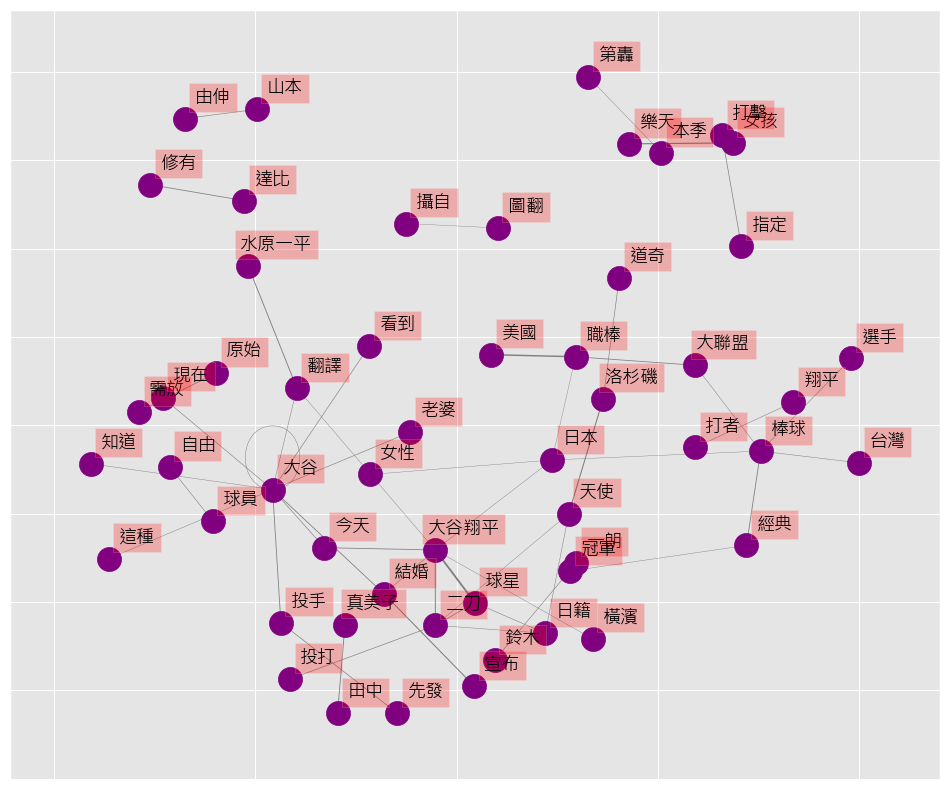

In [299]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

- 可看到("洛杉磯"、"職棒"、"天使"、"道奇"、"美國"、"大聯盟"),("打者"、"翔平"、"棒球"、"經典")等字詞常一起出現。

## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [300]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,大聯盟 投麥 感覺 超威 後面 方斯沃斯能 投麥 嚇死人 幾年 投麥 感覺 一大 查普曼 大...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05 22:31:19,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,媒體來源三立記者署名娛樂中心林亭妤報導完整新聞標題福原愛爆再婚被罵翻懶甩酸民突喊永遠幸福洩近...,三立 娛樂中心 林亭 福原 愛爆 再婚 甩酸民 突喊 永遠 幸福 近況 福原 愛在 去年 三...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09 01:29:17,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,有沒有如果大谷翔平加入女偶像團體唱唱跳跳右邊這神似大谷妹妹是不是看起來還不錯可愛,大谷翔平 加入 偶像 團體 唱唱 跳跳 右邊 神似 大谷 妹妹 不錯 可愛


In [301]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一位,一堆,一場,一天,一平,一年,一朗,一次,一點,三振,...,雙刀,電視,需要,面對,韓國,領先,體育,高中,高中生,鱒魚
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [302]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一位,一堆,一場,一天,一平,一年,一朗,一次,一點,...,雙刀,電視,需要,面對,韓國,領先,體育,高中,高中生,鱒魚
0,一位,1.000000,0.021135,0.038213,0.076408,-0.000242,-0.004555,0.014858,0.036987,0.020003,...,-0.004093,0.038145,0.081401,0.014265,0.027319,-0.016058,0.091867,-0.009979,-0.015842,0.019537
1,一堆,0.021135,1.000000,-0.002542,0.018829,-0.018299,0.093226,0.013932,-0.005355,0.057004,...,0.012597,0.008699,0.021627,-0.025162,0.000597,-0.026353,0.061753,0.006050,0.001594,-0.002917
2,一場,0.038213,-0.002542,1.000000,0.023111,-0.013239,-0.016262,-0.010438,0.028887,0.047898,...,-0.003268,-0.014012,0.058163,0.108642,0.002260,0.010887,0.048380,0.057105,0.018890,-0.002535
3,一天,0.076408,0.018829,0.023111,1.000000,-0.014959,0.031005,-0.011793,0.084700,0.031654,...,0.007881,-0.015832,-0.009334,0.049243,-0.004290,0.008567,0.036391,0.003752,0.005229,-0.004504
4,一平,-0.000242,-0.018299,-0.013239,-0.014959,1.000000,0.005213,-0.008320,-0.016682,0.004646,...,-0.013492,-0.000008,-0.009336,0.018958,0.011267,-0.012393,-0.004030,-0.007701,-0.012227,-0.011276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,領先,-0.016058,-0.026353,0.010887,0.008567,-0.012393,0.008155,-0.001610,0.008389,-0.017201,...,0.048080,-0.013117,-0.006216,0.092999,0.076339,1.000000,-0.015263,-0.009044,-0.014358,-0.013241
296,體育,0.091867,0.061753,0.048380,0.036391,-0.004030,0.049412,0.052514,0.083781,0.025334,...,-0.016616,0.016353,0.116473,0.015414,0.082940,-0.015263,1.000000,0.039067,0.029745,0.024107
297,高中,-0.009979,0.006050,0.057105,0.003752,-0.007701,0.029904,-0.006072,0.118691,0.024132,...,0.011682,0.016021,0.056694,0.075405,0.009581,-0.009044,0.039067,1.000000,0.152934,-0.008228
298,高中生,-0.015842,0.001594,0.018890,0.005229,-0.012227,0.025343,-0.009639,0.069231,-0.016970,...,-0.015631,-0.012940,-0.007629,0.010209,0.017851,-0.014358,0.029745,0.152934,1.000000,0.005701


In [303]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
25071,樂天,女孩,0.904350
51383,女孩,樂天,0.904350
64705,田中,真美子,0.900988
61715,真美子,田中,0.900988
2084,鈴木,一朗,0.823194
85206,一朗,鈴木,0.823194
10779,達比,修有,0.809542
83735,修有,達比,0.809542
65573,橫濱,福原,0.704700
52118,福原,橫濱,0.704700


### 5.1 和 「體育」, 「日本」 相關性最高的 10 個詞彙

In [304]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "體育")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "日本")].sort_values(by = ['cor'], ascending = False).head(10)

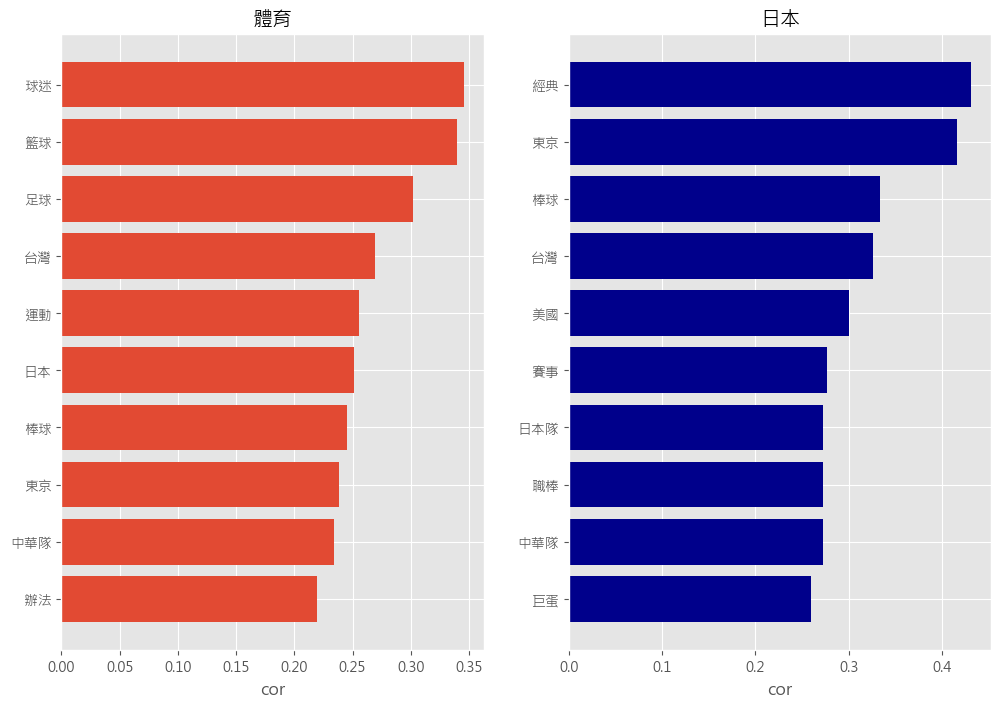

In [305]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('體育')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('日本')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

- 可看到 體育和("籃球"、"足球"、"運動"、"棒球")這些詞的相關性比較高。
- 可看到 日本和("東京"、"棒球"、台灣)這些詞的相關性比較高。

###  使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [306]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [307]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,先發,三振,0.343131
1,本季,三振,0.305914
2,大谷翔平,二刀,0.367497
3,三振,先發,0.343131
4,本季,先發,0.336707
...,...,...,...
115,球員,選手,0.405819
116,經典,選手,0.423232
117,美國,選手,0.370616
118,職棒,選手,0.533116


In [308]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

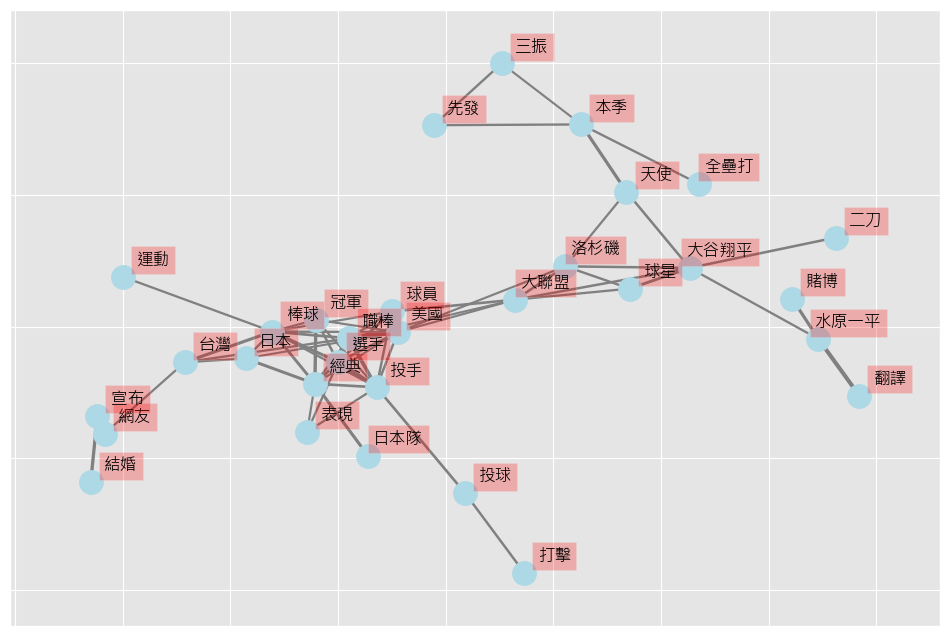

In [328]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

- 可看到("投手"、"職棒"、"美國"、"日本"、"經典"、"棒球")這些字眼常一起出現。

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章  

In [310]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03 15:37:54,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題我在王建民那年代開始看大聯盟的那時候看王建民投麥感覺就超威後面還一個方斯沃斯能投麥就真的...,大聯盟 投麥 感覺 超威 後面 方斯沃斯能 投麥 嚇死人 幾年 投麥 感覺 一大 查普曼 大...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05 22:31:19,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,媒體來源三立記者署名娛樂中心林亭妤報導完整新聞標題福原愛爆再婚被罵翻懶甩酸民突喊永遠幸福洩近...,三立 娛樂中心 林亭 福原 愛爆 再婚 甩酸民 突喊 永遠 幸福 近況 福原 愛在 去年 三...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09 01:29:17,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,有沒有如果大谷翔平加入女偶像團體唱唱跳跳右邊這神似大谷妹妹是不是看起來還不錯可愛,大谷翔平 加入 偶像 團體 唱唱 跳跳 右邊 神似 大谷 妹妹 不錯 可愛


In [311]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一位,一堆,一場,一天,一平,一年,一朗,一次,一點,三振,...,雙刀,電視,需要,面對,韓國,領先,體育,高中,高中生,鱒魚
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.094393,0.0,0.0,0.0,0.0,...,0.0,0.095167,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.070124,0.156067,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.297916,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0.0,0.0,0.0,0.0,0.0,0.625463,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2662,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2663,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2664,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


計算文章間的cosine similarity

In [312]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [313]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.000000
2,0.013578
3,0.033904
4,0.000000
...,...
2661,0.022245
2662,0.010747
2663,0.017965
2664,0.037346


In [314]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[問卦]為什麼大聯盟能投100英哩的變那麼多？,https://www.ptt.cc/bbs/Gossiping/M.1641195476....
2317,0.668550,[問卦]大谷是不是很容易外遇,https://www.ptt.cc/bbs/Gossiping/M.1710594984....
2491,0.599254,[問卦]450萬美金給你，但是屁股要給大谷用要嗎,https://www.ptt.cc/bbs/Gossiping/M.1711004069....
2265,0.594606,[問卦]馬斯克、祖克柏跟大谷翔平哪個精子比較好,https://www.ptt.cc/bbs/Gossiping/M.1710247608....
508,0.588439,[問卦]大谷翔平跟館長啊秋把誰贏？,https://www.ptt.cc/bbs/Gossiping/M.1678114012....
503,0.550754,[問卦]力宏跟大谷,https://www.ptt.cc/bbs/Gossiping/M.1678106310....
2230,0.537731,[問卦]納粹優生學搞得出大谷翔平這樣的人嗎,https://www.ptt.cc/bbs/Gossiping/M.1709306153....
1705,0.508920,[問卦]大家最希望大谷去哪隊？,https://www.ptt.cc/bbs/Gossiping/M.1701969053....
1561,0.493683,[問卦]大谷翔平職業前期在打混嗎?,https://www.ptt.cc/bbs/Gossiping/M.1692191841....
743,0.476264,[問卦]今天大谷的球「感覺」比朗希難打？,https://www.ptt.cc/bbs/Gossiping/M.1679454417....


檢視與第2317篇文章相似的文章

In [331]:
cos_df_14 = pd.DataFrame(cosine_matrix[2317], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
2317,1.000000,[問卦]大谷是不是很容易外遇,https://www.ptt.cc/bbs/Gossiping/M.1710594984....
2491,0.960883,[問卦]450萬美金給你，但是屁股要給大谷用要嗎,https://www.ptt.cc/bbs/Gossiping/M.1711004069....
508,0.846422,[問卦]大谷翔平跟館長啊秋把誰贏？,https://www.ptt.cc/bbs/Gossiping/M.1678114012....
503,0.823804,[問卦]力宏跟大谷,https://www.ptt.cc/bbs/Gossiping/M.1678106310....
2265,0.819674,[問卦]馬斯克、祖克柏跟大谷翔平哪個精子比較好,https://www.ptt.cc/bbs/Gossiping/M.1710247608....
1705,0.746791,[問卦]大家最希望大谷去哪隊？,https://www.ptt.cc/bbs/Gossiping/M.1701969053....
667,0.708367,[問卦]大谷大大何許人也？,https://www.ptt.cc/bbs/Gossiping/M.1679059306....
0,0.668550,[問卦]為什麼大聯盟能投100英哩的變那麼多？,https://www.ptt.cc/bbs/Gossiping/M.1641195476....
1906,0.630554,[問卦]台灣為什麼沒有出一個大谷翔平？,https://www.ptt.cc/bbs/Gossiping/M.1704165568....
956,0.611403,[問卦]愛菜跟大谷梗,https://www.ptt.cc/bbs/Gossiping/M.1679874305....


- 由於是八卦版，和2317相似文章多為探討大谷私下生活居多。

## 7. 建立Ngram預測模型

**使用我們的大谷翔平資料集**

In [316]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [317]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [318]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [332]:
text = '翻譯'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 水原一平, probability: 0.249
next word: 大谷, probability: 0.0345
next word: 水原, probability: 0.0268
next word: 涉賭, probability: 0.023
next word: 工作, probability: 0.0153


- 翻譯該詞預測下一個出現詞彙為水原一平、涉賭相關性最高。符合近期涉賭一案，預測結果還算可接受。

# 文件分類
- 目標 : 「文件分類」
- 內容 : 使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。

## 分析目標
+ 資料內容：
    + 資料來源：東森新聞
    + 版別：財經、政治、體育

* 分析主題：將東森新聞三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為分析目標：
    1. 如何以數字向量代表一篇文章
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

##  套件說明

- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [320]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

Text(0.5, 1.0, '聲量圖')

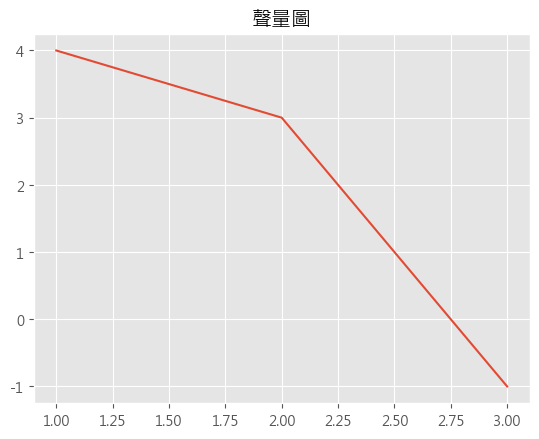

In [321]:
# https://zhuanlan.zhihu.com/p/566430362
# from matplotlib import font_manager
# font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

##  文字前處理

`east_news.csv`裡面包含了要分析的 東森新聞 資料。
- 版別：財經、政治、體育
- 時間範圍：2024/01/01 ~ 2024/03/31
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [322]:
udn = pd.read_csv("east_news.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,這檔股票漲幅逾4成 台股封關秀外資也買超它｜東森新聞,https://news.ebc.net.tw/news/article/398813,2024-01-01 13:13:00,財經,台股2023年封關秀精彩！外資買超前三為台積電、奇鋐、緯創，生技美時掛帥，中租-KY也躋進前...,EBC
1,2,Apple Pay狂跳「信用卡即將到期」 網哀號：時間還沒到｜東森新聞,https://news.ebc.net.tw/news/article/398817,2024-01-01 13:43:00,財經,近期有網友表示，自己的ApplePay出現奇怪的問題，明明綁定的信用卡還沒到期，但是Appl...,EBC
2,3,每人最高拿10萬！勞工紓困貸款1/5起可申請｜東森新聞,https://news.ebc.net.tw/news/article/398945,2024-01-02 11:28:00,財經,2024勞工紓困貸款將於1月5日起跑，每人最高可貸10萬，申請期間僅兩周，1月19日截止。銀...,EBC


In [323]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 1892
date range: ('2024-01-01 07:44:00', '2024-03-31 22:51:00')
category: 
artCatagory
政治    1321
財經     325
體育     246
Name: count, dtype: int64


###  清理斷句、斷詞(停用字、標點符號)

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [324]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,這檔股票漲幅逾成台股封關秀外資也買超它東森新聞,https://news.ebc.net.tw/news/article/398813,2024-01-01 13:13:00,財經,台股年封關秀精彩外資買超前三為台積電奇鋐緯創生技美時掛帥中租也躋進前名榜單明天新年第一天開市...,EBC
1,2,狂跳信用卡即將到期網哀號時間還沒到東森新聞,https://news.ebc.net.tw/news/article/398817,2024-01-01 13:43:00,財經,近期有網友表示自己的出現奇怪的問題明明綁定的信用卡還沒到期但是卻一直顯示即將到期而無法使用不...,EBC
2,3,每人最高拿萬勞工紓困貸款起可申請東森新聞,https://news.ebc.net.tw/news/article/398945,2024-01-02 11:28:00,財經,勞工紓困貸款將於月日起跑每人最高可貸萬申請期間僅兩周月日截止銀行指出經勞保局核准後個營業日內...,EBC


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [325]:
udn['content'] = udn.apply(lambda row: row['artTitle'] + row['artContent'], axis=1)
udn = udn[['content', 'artUrl', 'artCatagory']]
udn.head()

,content,artUrl,artCatagory
0,這檔股票漲幅逾成台股封關秀外資也買超它東森新聞台股年封關秀精彩外資買超前三為台積電奇鋐緯創生...,https://news.ebc.net.tw/news/article/398813,財經
1,狂跳信用卡即將到期網哀號時間還沒到東森新聞近期有網友表示自己的出現奇怪的問題明明綁定的信用卡...,https://news.ebc.net.tw/news/article/398817,財經
2,每人最高拿萬勞工紓困貸款起可申請東森新聞勞工紓困貸款將於月日起跑每人最高可貸萬申請期間僅兩周...,https://news.ebc.net.tw/news/article/398945,財經
3,台積電最高位女將進董事會呼聲高何麗梅成總座大熱門東森新聞台積電人力資源副總經理何麗梅傳出被提...,https://news.ebc.net.tw/news/article/399081,財經
4,東區新店王藏地下室量販店萬月租包樓東森新聞地上看一間店面的大小走下去竟是坪的超大地下室再看看...,https://news.ebc.net.tw/news/article/399115,財經


In [326]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 1892


###  斷詞

In [334]:
# 設定繁體中文詞庫
jieba.set_dictionary("dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [335]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [336]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from c:\Users\fisha\OneDrive\桌面\HW2\dict.txt.big ...
Loading model from cache C:\Users\fisha\AppData\Local\Temp\jieba.ua5de2fb36135ead1bb22f4d3d78d83e9.cache
Loading model cost 1.325 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,這檔股票漲幅逾成台股封關秀外資也買超它東森新聞台股年封關秀精彩外資買超前三為台積電奇鋐緯創生...,https://news.ebc.net.tw/news/article/398813,財經,這檔 股票 漲幅 逾成 台股 封關 外資 買超 東森 台股 封關 精彩 外資 超前 三為 台...
1,狂跳信用卡即將到期網哀號時間還沒到東森新聞近期有網友表示自己的出現奇怪的問題明明綁定的信用卡...,https://news.ebc.net.tw/news/article/398817,財經,信用卡 到期 哀號 還沒到 東森 近期 網友 出現 奇怪 明明 綁定 信用卡 還沒 到期 顯...
2,每人最高拿萬勞工紓困貸款起可申請東森新聞勞工紓困貸款將於月日起跑每人最高可貸萬申請期間僅兩周...,https://news.ebc.net.tw/news/article/398945,財經,每人 最高 勞工 貸款 申請 東森 勞工 貸款 將於月 起跑 每人 最高 可貸 申請 期間 ...
3,台積電最高位女將進董事會呼聲高何麗梅成總座大熱門東森新聞台積電人力資源副總經理何麗梅傳出被提...,https://news.ebc.net.tw/news/article/399081,財經,台積電 最高 女將 董事會 呼聲 高何麗梅成 總座 熱門 東森 台積電 人力資源 副總經理 ...
4,東區新店王藏地下室量販店萬月租包樓東森新聞地上看一間店面的大小走下去竟是坪的超大地下室再看看...,https://news.ebc.net.tw/news/article/399115,財經,東區 新店 王藏 地下室 販店 月租 包樓 東森 地上 一間 店面 大小 下去 竟是 超大 ...


###  資料集基本檢視

檢視資料內容

In [337]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 1892
category: 
artCatagory
政治    1321
財經     325
體育     246
Name: count, dtype: int64


- 可看出共有1892篇文章(3種不同版別的文章數)

##  分類模型的訓練流程
###  根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [338]:
data = udn
X = data["words"]
y = data["artCatagory"]  #預測目標

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

87      快訊 震驚 投資 名人 明山 癌逝 享年 不到 東森 元大金控 旗下 元大 證券 執行 副總...
1188    今年 最難 韓國 院長 燙金 落款 春聯 數量 有限 東森 新任 立法 院長 韓國 春聯 曝...
289     著台 積電 走不動 日經 供應鏈 赴美 喊卡 東森 外媒 白宮 今天 宣布 拜登 政府 晶片...
1420    國民黨 啟動 組織 改造 擬將 復興 整合 地方 黨部 東森 國民黨 主席 朱立倫將 國民黨...
679     政治 觀察室 決戰 選前 之夜 侯賴 板橋 人氣 柯凱道 衝刺 東森 今天 選前 一天 各政...
Name: words, dtype: object
87      財經
1188    政治
289     財經
1420    政治
679     政治
Name: artCatagory, dtype: object


In [339]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
政治    69.820296
財經    17.177590
體育    13.002114
Name: proportion, dtype: float64

train percentage :
artCatagory
政治    70.694864
財經    17.069486
體育    12.235650
Name: proportion, dtype: float64

test percentage :
artCatagory
政治    67.781690
財經    17.429577
體育    14.788732
Name: proportion, dtype: float64


- 可看出raw data和切分後的data各版別的比例皆相同。

###  將文章轉為 DTM

###  套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [340]:
vectorizer = CountVectorizer(max_features=150)
print(vectorizer)

CountVectorizer(max_features=150)



- 由於財經、體育文章數較少，max_features設為150，以最常出現詞彙150作為標準。

In [341]:
X_train.head()

87      快訊 震驚 投資 名人 明山 癌逝 享年 不到 東森 元大金控 旗下 元大 證券 執行 副總...
1188    今年 最難 韓國 院長 燙金 落款 春聯 數量 有限 東森 新任 立法 院長 韓國 春聯 曝...
289     著台 積電 走不動 日經 供應鏈 赴美 喊卡 東森 外媒 白宮 今天 宣布 拜登 政府 晶片...
1420    國民黨 啟動 組織 改造 擬將 復興 整合 地方 黨部 東森 國民黨 主席 朱立倫將 國民黨...
679     政治 觀察室 決戰 選前 之夜 侯賴 板橋 人氣 柯凱道 衝刺 東森 今天 選前 一天 各政...
Name: words, dtype: object

In [342]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<1324x150 sparse matrix of type '<class 'numpy.int64'>'
	with 24627 stored elements in Compressed Sparse Row format>

In [343]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  6, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0, 10,  3],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [344]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])


['一次' '下午' '中國' '中央' '中華民國' '主席' '之後' '事件' '事情' '人員']


In [347]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['中國']

{'投資': 55, '東森': 72, '傳出': 17, '市場': 46, '相關': 94, '討論': 117, '準備': 81, '外界': 39, '透露': 129, '工作': 45, '今年': 11, '韓國': 146, '院長': 142, '立法': 98, '有人': 70, '發現': 90, '民眾': 76, '立法院': 99, '進入': 130, '看到': 95, '國民黨': 35, '立委': 97, '支持者': 63, '總統': 104, '英文': 111, '一次': 0, '當選': 88, '認為': 119, '清德': 80, '透過': 128, '地方': 37, '台北': 25, '市長': 47, '萬安': 113, '政治': 65, '今天': 10, '宣布': 43, '政府': 64, '美國': 106, '台積電': 28, '現在': 85, '台灣': 27, '重要': 139, '合作': 29, '能夠': 108, '主席': 5, '進行': 131, '黃國': 148, '人員': 9, '持續': 56, '包括': 23, '擔任': 61, '最大': 69, '選前': 133, '選票': 137, '侯友宜': 14, '今日': 12, '新北': 67, '藍綠': 115, '柯文': 73, '國際': 36, '記者會': 118, '超過': 126, '兩岸': 18, '議題': 122, '提到': 60, '過去': 132, '政黨': 66, '民進黨': 77, '賴清德': 125, '選戰': 135, '競選': 101, '分區': 22, '面對': 145, '投票': 54, '代表': 13, '知道': 96, '機會': 74, '去年': 24, '對此': 44, '決定': 78, '員工': 31, '大選': 41, '選舉': 138, '台北市': 26, '公布': 19, '自行': 110, '候選人': 16, '選民': 136, '倒數': 15, '提出': 59, '希望': 48, '支持': 62, '發言人': 92, '回應': 32, '黨團': 149, '

2

查看vocabulary各字詞及"中國"一詞的index。

In [348]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(1324, 150)
(568, 150)


In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
clf.classes_

array(['政治', '財經', '體育'], dtype=object)

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['政治' '政治' '政治' '政治' '體育' '財經' '政治' '政治' '政治' '政治']


- 得到前10篇測試文章的預測版別。

In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(568, 3)


array([9.99999840e-01, 1.46487395e-07, 1.39241434e-08])

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          政治       0.97      0.97      0.97       385
          財經       0.91      0.86      0.89        99
          體育       0.83      0.89      0.86        84

    accuracy                           0.94       568
   macro avg       0.90      0.91      0.90       568
weighted avg       0.94      0.94      0.94       568



In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[372,   5,   8],
       [  7,  85,   7],
       [  6,   3,  75]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '政治'), Text(0, 1.5, '財經'), Text(0, 2.5, '體育')])

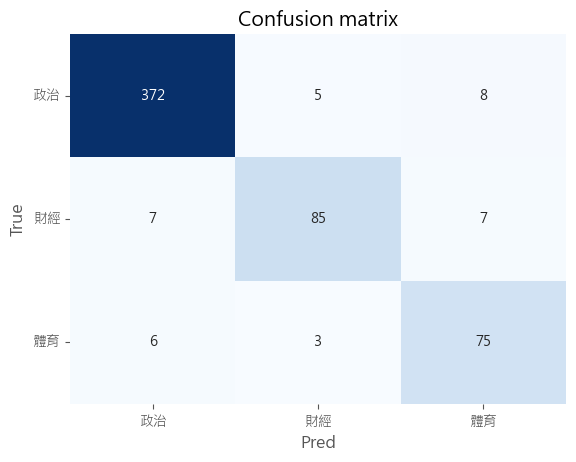

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

- 可看到對角線的值均較大，代表模型的分類效果佳

###  tfidf
改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [349]:
vectorizer = TfidfVectorizer(max_features=150)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.23965584, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.23364279,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.25030266, 0.51851817, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.57393928, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.08513678, 0.        , 0.     

In [350]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          政治       0.94      0.99      0.97       385
          財經       0.90      0.92      0.91        99
          體育       0.98      0.74      0.84        84

    accuracy                           0.94       568
   macro avg       0.94      0.88      0.91       568
weighted avg       0.94      0.94      0.94       568



- 以上述轉換後的tf-idf的資料進行分類器訓練，可看出"體育"版別結果較佳，可能體育用字差異較大。

###  CV
cross-validation-->CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [351]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=150).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.03150582, 0.02683401, 0.02699471, 0.024575  , 0.02601862]),
 'score_time': array([0.01008701, 0.00854611, 0.00848556, 0.00909281, 0.01049852]),
 'test_f1_macro': array([0.87479811, 0.8962029 , 0.91729148, 0.87053186, 0.91918775]),
 'test_precision_macro': array([0.89841935, 0.90828924, 0.9457583 , 0.91722917, 0.95973738]),
 'test_recall_macro': array([0.8597177 , 0.8891253 , 0.8983165 , 0.84468212, 0.88826377])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [352]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          政治       0.96      0.99      0.97       936
          財經       0.90      0.88      0.89       226
          體育       0.92      0.75      0.83       162

    accuracy                           0.94      1324
   macro avg       0.92      0.88      0.90      1324
weighted avg       0.94      0.94      0.94      1324



以此方式進行預測，結果也都有9成以上，代表效果不錯。

##  比較不同模型效果

In [353]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          政治       0.96      0.99      0.97       936
          財經       0.90      0.88      0.89       226
          體育       0.92      0.75      0.83       162

    accuracy                           0.94      1324
   macro avg       0.92      0.88      0.90      1324
weighted avg       0.94      0.94      0.94      1324



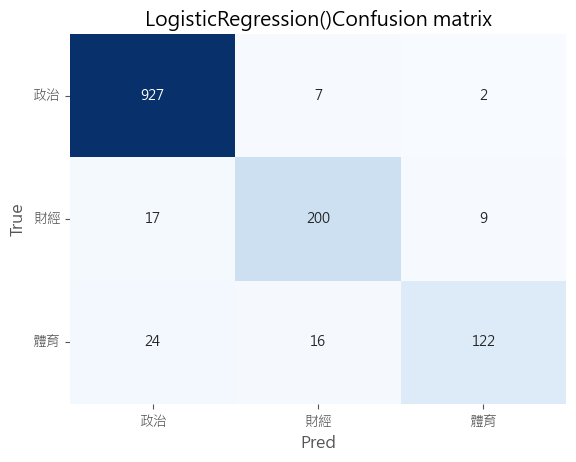

In [354]:
vectorizer = TfidfVectorizer(max_features=150)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          政治       0.96      0.99      0.97       936
          財經       0.90      0.88      0.89       226
          體育       0.92      0.75      0.83       162

    accuracy                           0.94      1324
   macro avg       0.92      0.88      0.90      1324
weighted avg       0.94      0.94      0.94      1324

now training: clf_dtree
              precision    recall  f1-score   support

          政治       0.95      0.94      0.94       936
          財經       0.78      0.79      0.79       226
          體育       0.76      0.79      0.78       162

    accuracy                           0.90      1324
   macro avg       0.83      0.84      0.84      1324
weighted avg       0.90      0.90      0.90      1324

now training: clf_svm


              precision    recall  f1-score   support

          政治       0.96      0.99      0.97       936
          財經       0.89      0.89      0.89       226
          體育       0.95      0.76      0.84       162

    accuracy                           0.94      1324
   macro avg       0.93      0.88      0.90      1324
weighted avg       0.94      0.94      0.94      1324

now training: clf_rf
              precision    recall  f1-score   support

          政治       0.97      0.98      0.97       936
          財經       0.86      0.90      0.88       226
          體育       0.93      0.81      0.86       162

    accuracy                           0.95      1324
   macro avg       0.92      0.90      0.91      1324
weighted avg       0.95      0.95      0.95      1324



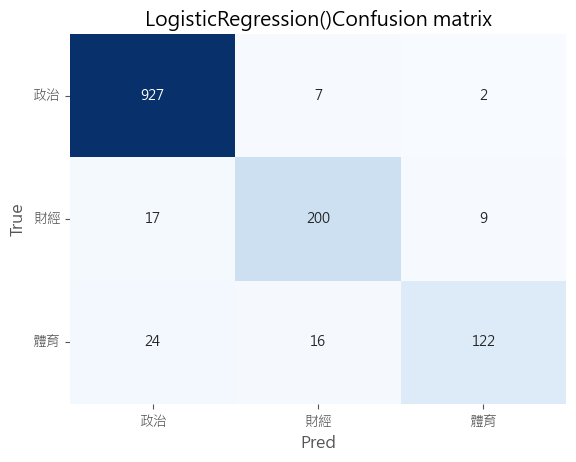

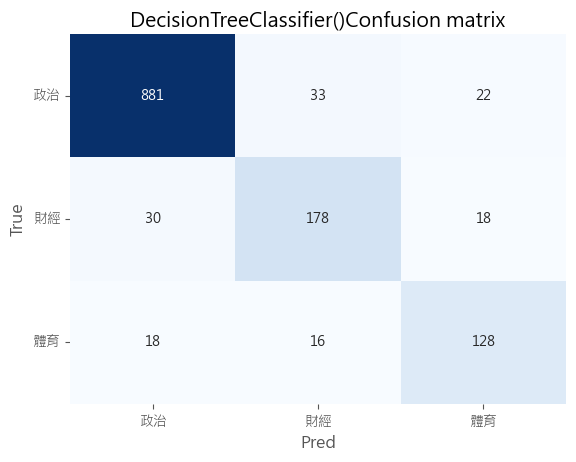

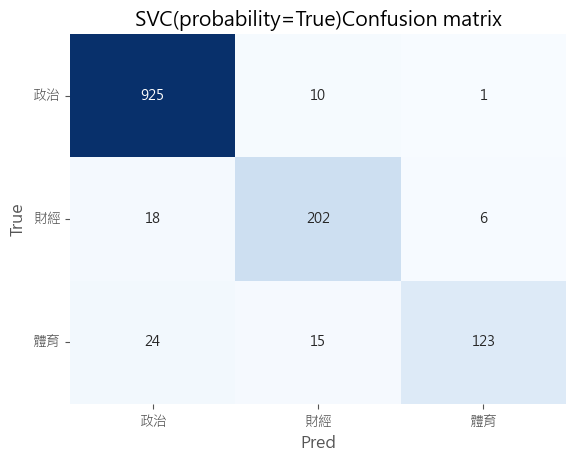

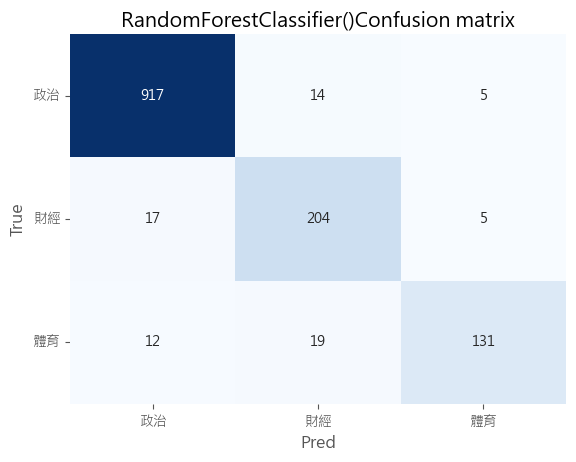

In [355]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVM的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=150)
vectorizer = TfidfVectorizer(max_features=150)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


- 從結果可看出 clf_dtree 分類效果較差(財經、體育僅有7成準確率)，而clf_rf 分類效果較佳。

In [356]:
result_set['clf_logistic']

{'政治': {'precision': 0.9576446280991735,
  'recall': 0.9903846153846154,
  'f1-score': 0.9737394957983193,
  'support': 936.0},
 '財經': {'precision': 0.8968609865470852,
  'recall': 0.8849557522123894,
  'f1-score': 0.89086859688196,
  'support': 226.0},
 '體育': {'precision': 0.9172932330827067,
  'recall': 0.7530864197530864,
  'f1-score': 0.8271186440677967,
  'support': 162.0},
 'accuracy': 0.9433534743202417,
 'macro avg': {'precision': 0.9239329492429885,
  'recall': 0.8761422624500304,
  'f1-score': 0.8972422455826919,
  'support': 1324.0},
 'weighted avg': {'precision': 0.9423319173866057,
  'recall': 0.9433534743202417,
  'f1-score': 0.9416538453939071,
  'support': 1324.0}}

In [357]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'accuracy': 0.945619335347432,
 'macro avg': {'f1-score': 0.906797063246651,
               'precision': 0.9197273722449254,
               'recall': 0.8969992324220447,
               'support': 1324.0},
 'weighted avg': {'f1-score': 0.9451360117550655,
                  'precision': 0.9458828079899528,
                  'recall': 0.945619335347432,
                  'support': 1324.0},
 '政治': {'f1-score': 0.9744952178533475,
        'precision': 0.9693446088794926,
        'recall': 0.9797008547008547,
        'support': 936.0},
 '財經': {'f1-score': 0.8812095032397408,
        'precision': 0.8607594936708861,
        'recall': 0.9026548672566371,
        'support': 226.0},
 '體育': {'f1-score': 0.8646864686468646,
        'precision': 0.9290780141843972,
        'recall': 0.808641975308642,
        'support': 162.0}}


- 得出rf(random forest)在f1-score的指標下為分類最好的模型

In [358]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          政治       0.95      0.98      0.97       385
          財經       0.85      0.84      0.84        99
          體育       0.89      0.79      0.84        84

    accuracy                           0.93       568
   macro avg       0.90      0.87      0.88       568
weighted avg       0.92      0.93      0.92       568



- 以最好的'clf_rf'模型預測test data，也均有8成5的準確率。

In [371]:
model_set['clf_rf'].predict(vectorizer.transform(["基金 投資 高雄 東森 聯合 電動車 電池 手機"]).toarray())

array(['財經'], dtype=object)

- 最佳模型為clf_rf ，其中Decision Tree表現較差，另外三種表現差不多。

##  分析可解釋模型的結果

### 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [359]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

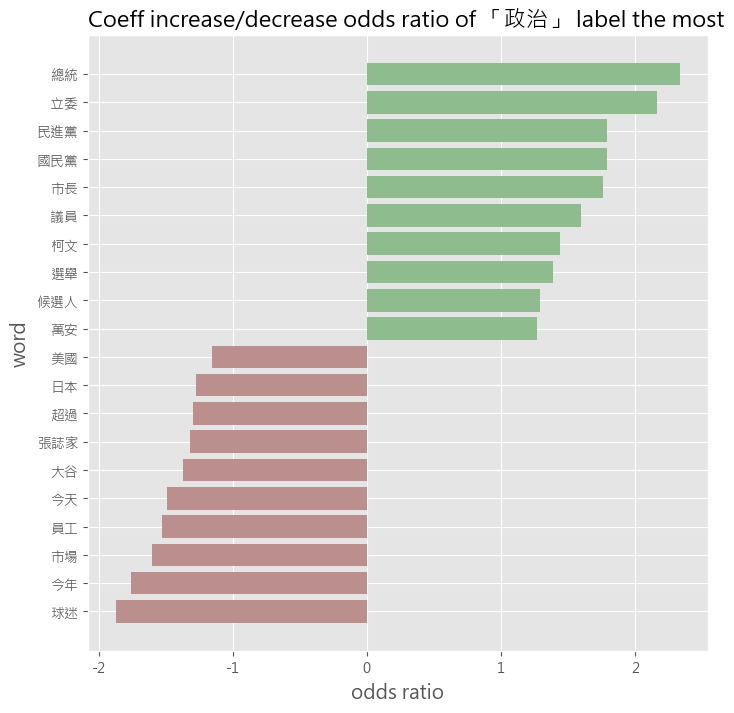

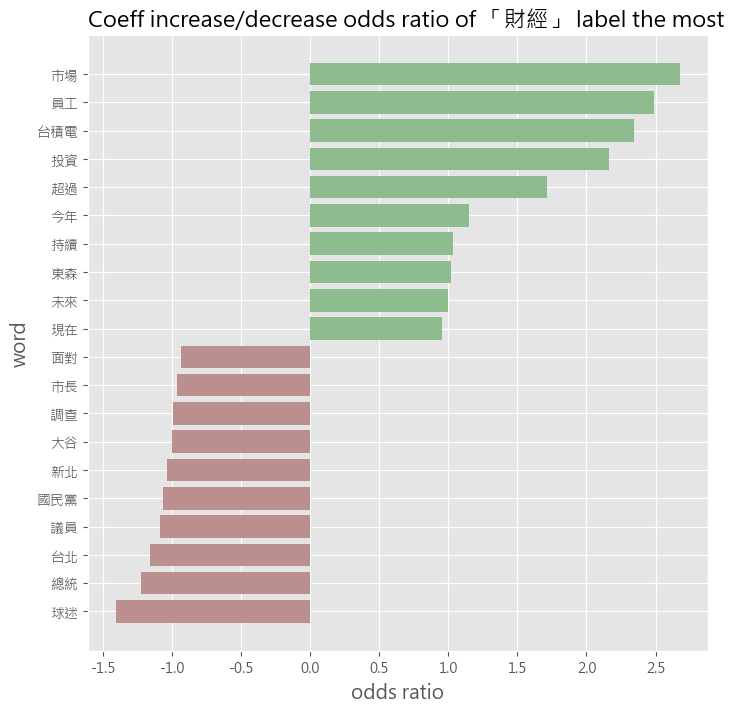

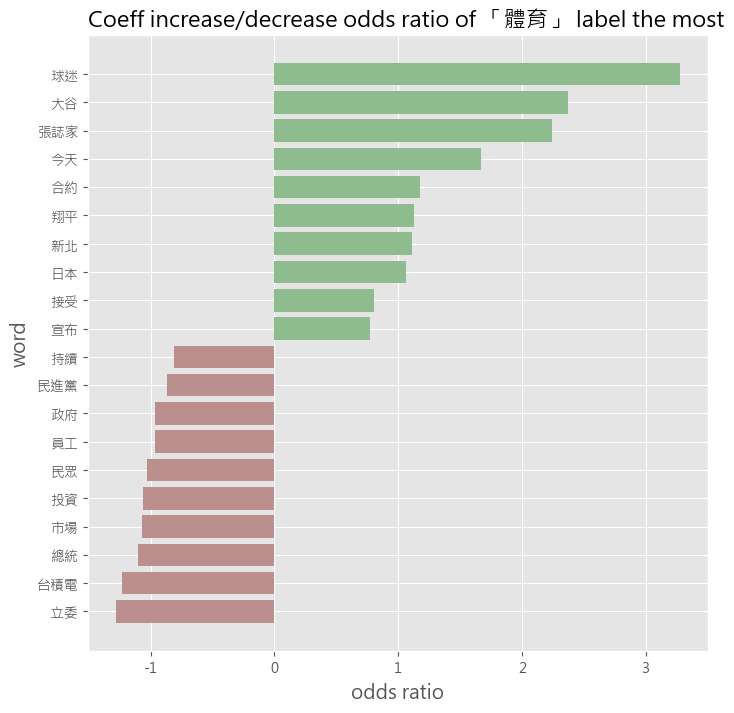

In [360]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

+ 「政治」中出現總統、國民黨、民進黨等新聞關鍵字眼。
+ 「財經」中出現市場、台積電、投資等關鍵字眼。
+ 「體育」中則出現球迷、大谷、翔平相關字眼。


## 預測新聞類別

`udn_news.csv` 為聯合新聞網資料
- 版別：運動、全球、社會、產經、股市
- 時間範圍：2024/03/15 ~ 2024/03/31
- 工作流程平台搜尋/排除關鍵字：無

In [361]:
ct = pd.read_csv("udn_new.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,MLB／曾說「不是朋友」成真 大谷翔平解除追蹤水原一平,2024/3/21 09:56,運動,https://udn.com/news/story/11247/7845714,曾經是形影不離的戰友，大谷翔平與水原一平如今因金錢關係成為陌生人，大谷翔平的個人社群也解除對...,UDN
1,2,MLB／水原一平涉賭被解僱 日本網友震驚「巨大背叛」,2024/3/21 10:28,運動,https://udn.com/news/story/11247/7845808,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭，已遭洛杉磯道奇解雇。大谷轉...,UDN
2,3,MLB／偷大谷翔平的錢還賭債！水原一平IG被球迷灌爆：你搞屁啊,2024/3/21 10:36,運動,https://udn.com/news/story/11247/7845856,美國職棒大聯盟（MLB）球星大谷翔平的隨行翻譯水原一平，因涉嫌竊取大谷至少450萬美元進行非...,UDN
3,4,MLB／國內球評看水原一平醜聞 形容「比大谷結婚令人震撼」,2024/3/21 10:56,運動,https://udn.com/news/story/11247/7845919,道奇、教士隊在南韓首爾進行新球季第2場比賽前，大谷翔平的翻譯水原一平遭球團開除，一位美職賽事...,UDN
4,5,MLB／大谷翔平恐受牽連？水原一平稱他曾代為轉帳償還賭債後才改口,2024/3/21 12:13,運動,https://udn.com/news/story/11247/7846177,美國職棒大聯盟明星大谷翔平的翻譯水原一平傳出涉賭，遭球隊解僱。水原美國時間19日接受ESPN...,UDN
...,...,...,...,...,...,...,...
9272,9275,鴻海、貿聯 四檔亮眼,2024/3/31 23:31,股市,https://udn.com/news/story/7255/7868565,根據美系券商最新報告指出，2024~2025年電動車電池價格將大幅下降，電動車售價亦將降價，...,UDN
9273,9276,全民權證／世界 挑價內外20%,2024/3/31 23:29,股市,https://udn.com/news/story/7255/7868567,世界（5347）表示，今年半導體市場是逐季加溫，即使中國大陸成熟製程開出產能，世界也不打價格...,UDN
9274,9277,全民權證／富邦金 兩檔搶鏡,2024/3/31 23:30,股市,https://udn.com/news/story/7255/7868570,富邦金（2881）2023年稅後益年增41%至660億元，去年第4季獲利受避險成本影響，每股...,UDN
9275,9278,全民權證／樺漢 選逾90天期,2024/3/31 23:30,股市,https://udn.com/news/story/7255/7868574,樺漢（6414）在手訂單良好，加上品牌通路營收提升，近年轉型聚焦高毛利的純軟及軟硬雲ESaa...,UDN


In [362]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,MLB／曾說「不是朋友」成真 大谷翔平解除追蹤水原一平曾經是形影不離的戰友，大谷翔平與水原一...,https://udn.com/news/story/11247/7845714,運動,MLB 朋友 大谷 翔平 解除 追蹤 水原 一平 曾經 形影不離 戰友 大谷 翔平 水原 一...
1,MLB／水原一平涉賭被解僱 日本網友震驚「巨大背叛」日本棒球明星大谷翔平的翻譯水原一平傳出涉...,https://udn.com/news/story/11247/7845808,運動,MLB 水原 一平 涉賭 解僱 日本 網友 震驚 巨大 背叛 日本 棒球 明星 大谷 翔平 ...
2,MLB／偷大谷翔平的錢還賭債！水原一平IG被球迷灌爆：你搞屁啊美國職棒大聯盟（MLB）球星大...,https://udn.com/news/story/11247/7845856,運動,MLB 大谷 翔平 錢還 賭債 水原 一平 IG 球迷 灌爆 美國 職棒 MLB 球星 大谷...
3,MLB／國內球評看水原一平醜聞 形容「比大谷結婚令人震撼」道奇、教士隊在南韓首爾進行新球季第...,https://udn.com/news/story/11247/7845919,運動,MLB 國內 球評 水原 一平 醜聞 形容 大谷 結婚 令人 震撼 道奇 教士 南韓 首爾 ...
4,MLB／大谷翔平恐受牽連？水原一平稱他曾代為轉帳償還賭債後才改口美國職棒大聯盟明星大谷翔平的...,https://udn.com/news/story/11247/7846177,運動,MLB 大谷 翔平 恐受 牽連 水原 一平稱 曾代為 轉帳 償還 賭債 改口 美國 職棒 明...


In [363]:
ct['artCatagory'].value_counts()

artCatagory
產經    2530
全球    2124
社會    2119
股市    1421
運動    1083
Name: count, dtype: int64

In [364]:
mapper = {"產經":"財經", "全球":"政治", "社會":"政治","股市":"財經", "運動":"體育"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          政治       0.77      0.49      0.60      4243
          財經       0.61      0.84      0.71      3951
          體育       0.66      0.69      0.68      1083

    accuracy                           0.66      9277
   macro avg       0.68      0.68      0.66      9277
weighted avg       0.69      0.66      0.65      9277



- 可看到在政治版別的文章預測結果還行，而在財經、體育的文章預測結果免強及格。

In [365]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,MLB 朋友 大谷 翔平 解除 追蹤 水原 一平 曾經 形影不離 戰友 大谷 翔平 水原 一...,體育,體育
1,MLB 水原 一平 涉賭 解僱 日本 網友 震驚 巨大 背叛 日本 棒球 明星 大谷 翔平 ...,體育,體育
2,MLB 大谷 翔平 錢還 賭債 水原 一平 IG 球迷 灌爆 美國 職棒 MLB 球星 大谷...,體育,體育
3,MLB 國內 球評 水原 一平 醜聞 形容 大谷 結婚 令人 震撼 道奇 教士 南韓 首爾 ...,體育,體育
4,MLB 大谷 翔平 恐受 牽連 水原 一平稱 曾代為 轉帳 償還 賭債 改口 美國 職棒 明...,體育,體育
...,...,...,...
9272,鴻海 貿聯 四檔 亮眼 美系 券商 最新 報告 指出 2024 2025 電動車 電池 價格...,財經,財經
9273,全民 權證 挑價 內外 20% 5347 今年 半導體 市場 逐季 加溫 中國 大陸 成熟 ...,財經,財經
9274,全民 權證 富邦金 兩檔 搶鏡 富邦金 2881 2023 稅後 益年 41% 660 億元...,財經,財經
9275,全民 權證 樺漢 90 天期 樺漢 6414 在手 訂單 良好 品牌 通路 營收 提升 近年...,財經,財經


In [366]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
68,LLB 謝國城 賽制 龜山 福林 少棒 強權 解析 遴選 LLB 少棒 威廉 波特 代表隊 ...,體育,財經
71,二輪 選秀 咖變 一線 球星 大頭 布朗 成就 尼克 紐約 尼克 後衛 大頭 布朗 NBA ...,體育,財經
72,愛德華 霸氣 比美 閃電俠 韋德 成狼王 瞄準 美國 王牌 灰狼 三月初 宣布 唐斯 Kar...,體育,財經
73,中職 樂天 後院 失火 何不 考慮 關門 樂天 桃猿 官辦 熱身賽 頻遭 對手 逆轉 敗有 ...,體育,財經
78,青春 風暴 加持 火箭 飛越 勇士 兩周前 擔心 勇士 西區 季後賽 附加賽 卡位 火箭 逼...,體育,財經
...,...,...,...
9244,電子 金融 期齊漲 台北 股市 今天 上漲 73.63 20200.12 電子 期收 106...,財經,體育
9253,期交所 縱橫 期海 大專院校 模擬 交易 競賽 日起 接受 報名 校園 年輕人 增進 期貨 ...,財經,政治
9254,期交所 2024 大專院校 模擬 交易 競賽 日起 接受 報名 臺灣 期貨 交易所 校園 年...,財經,政治
9264,月台 期指 78 台北 股市 今天 終場 147.9 20294.45 月台 指期 2028...,財經,體育


- 過濾出被分類到和真實版別不同的文章有哪些。

In [367]:
false_pred.loc[false_pred['artCatagory']=='財經', :].head(50)

,words,artCatagory,pred
5328,人壽 退休 調查 女性 退休 規畫 準備 壓力 值比 男性 女性 扮演 角色 人生 階段 轉...,財經,政治
5354,晉升 主管 討厭 特殊 工具 贏得 支持 拓展 良好 關係 部門 主任 整個 企業 主管 家...,財經,政治
5356,電價 漲雙鐵 票價 著漲 尊重 台鐵 決定 電價 審議 委員會 將於 22 召開 電價 漲幅...,財經,政治
5357,電價 調升 柯文 光電 風電 綠電 吃飽 台電 虧損 電價 預期 平均 調幅 11% 對此 ...,財經,政治
5358,工商 民生 用電 漲價 柯文 哲批 台電 虧損 綠電 吃飽 經濟部 今天 召開 電價 費率 ...,財經,政治
5361,電價 漲帶 物價 趙少康 民眾 至少 三層 電價 全面 調漲 各界 帶動 物價上漲 對此 資...,財經,政治
5362,環團 聲明 支持 合理 調整 電價 籲推 對策 帶動 節電 電價 審議 委員會 今天 召開 ...,財經,政治
5363,電費 調漲 雙鐵 票價 萬安 北捷 凍漲 經濟部 電價 審議 委員會 電費 要漲 行業 恐將...,財經,政治
5364,電價 調漲 捷運 去年 用電 1.44 新北 捷運 爭取 凍漲 經濟部 今開 電價 費率 審...,財經,政治
5365,電費 喊漲 大學 國立 科大 協進會 補助 到位 教育部 表態 台電 電價 審議 今天下午 ...,財經,體育


- 可看出真實版別"財經多被分類到"政治"。

In [368]:
false_pred.loc[5427, :]

words          經濟部 小店 夏天 電費 一次 冷氣 上門 經濟部 拍板 平均 電價 調漲 11% 立委 廷...
artCatagory                                                   財經
pred                                                          政治
Name: 5427, dtype: object

In [369]:
pprint(false_pred['words'][5427])

('經濟部 小店 夏天 電費 一次 冷氣 上門 經濟部 拍板 平均 電價 調漲 11% 立委 廷瑋 經濟部 試圖 解釋 電價 小家庭 小店 漲幅 輕微 主要 '
 '大戶 調漲 指出 小店 夏天 冷氣 電費 一次 2.5 萬元 大熱天 如省 冷氣 上門 漲價 顧客 苦不堪言 廷瑋 經濟部 漲價 消息 一出 民眾 炸鍋 '
 '小羅 服務處 電話 接到 手軟 家人 牛肉 附近 小吃攤 業者 訴苦 廷瑋 拿出 小店 電費 冬天 電費 繳約 1.5 夏天 冷氣 2.5 萬元 擔心 '
 '這波 漲價 影響 夏季 用電 是非 夏季 用電 電費 利潤 貼補 開業 成本 再漲 關店 反映 餐飲 價格 業者 擔心 消費者 上門 指出 生產 用電 '
 '工廠 用電 轉動 機器 農產 用電 保持 冷藏 大戶 調漲 等於 生產 成本增加 最終 反應 產品價格 進一步 推升 物價 餐飲 小店 被迫 漲價 '
 '小市民 埋單 廷瑋 國際 燃料 價格 戰爭 中油 轉虧 為盈 在野 立法委員 要求 緩漲 電價 地方 政府 呼籲 緩漲 電價 吶喊 緩漲 電價 各界 '
 '呼籲 中央 緩漲 中央 一意孤行 違逆 民意 政府 終將 民意 反噬')


- 可發現抽取此篇文章中，因為多出現"經濟部"、"立委"、"中央"、"民意"、"政府"等關鍵詞，使模型預測成「政治」。